# V1 - 8 orientations (simple + complex) histogram of activation
<br>
<br>
Layer 1) Retina (Photoreceptors) <br>
<br>
Layer 2) LGN (Ganglion cells) <br>
&emsp; &emsp; &emsp; - Scale A (single pixel) -> Layer 28x28 <br> 
&emsp; &emsp; &emsp; - Scale B (2x2 mean) -> Layer 14x14 <br>
&emsp; &emsp; &emsp; - Scale C (4x4 mean) -> Layer 7x7 <br>
<br>
Layer 3) V1 (Simple cells) -> 5x1 RF <br>
&emsp; &emsp; &emsp; - LGN A -> V1 A (28 x 28 x 8) <br> 
&emsp; &emsp; &emsp; - LGN B -> V1 B (14 x 14 x 8) <br>
&emsp; &emsp; &emsp; - LGN C -> V1 C (7 x 7 x 8) <br>
<br>
Layer 4) LGN (Complex cells) <br><br>
&emsp; &emsp; - V1 A: <br> 
&emsp; &emsp; &emsp; - Scale A (3x3 gaussian kernel) -> Layer 10 x 10 x 8 (2-pixel padding) <br> 
&emsp; &emsp; &emsp; - Scale B (5x5 gaussian kernel) -> Layer 6 x 6 x 8 (2-pixel padding) <br>
&emsp; &emsp; &emsp; - Scale C (7x7 gaussian kernel) -> Layer 4 x 4 x 8 (no padding) <br><br>
&emsp; &emsp; - V1 B: <br>
&emsp; &emsp; &emsp; - Scale A (3x3 gaussian kernel) -> Layer 5 x 5 x 8 (1-pixel padding) <br> 
&emsp; &emsp; &emsp; - Scale B (5x5 gaussian kernel) -> Layer 3 x 3 x 8 (1-pixel padding) <br>
&emsp; &emsp; &emsp; - Scale C (7x7 gaussian kernel) -> Layer 2 x 2 x 8 (no padding) <br><br>
&emsp; &emsp; - V1 C: <br>
&emsp; &emsp; &emsp; - Scale A (3x3 gaussian kernel) -> Layer 3 x 3 x 8 (2-pixel padding) <br> 
&emsp; &emsp; &emsp; - Scale B (5x5 gaussian kernel) -> Layer 2 x 2 x 8 (3-pixel padding) <br>
&emsp; &emsp; &emsp; - Scale C (7x7 gaussian kernel) -> Layer 1 x 1 x 8 (no padding) <br><br>

Hint: the average almost always turns out to be near 0, so perhaps it is better to keep cells that are turned off as inhibitory and those that are activated (even if very little) as excitatory

In [12]:
from brian2 import *
%matplotlib inline
import numpy as np
import pytime

x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
t_train = np.load('t_train.npy')
t_test = np.load('t_test.npy')

n = 28
pat = x_train[0,:].reshape(n,n)/255

def hist_V1(mfr, n, FR):

    titles = ['0°','30°','45°','60°','90°','120°','135°','150°']
    nL = n**2
    
    for ii in range(8):
        
        a = asarray(mfr[nL*ii : nL*(ii+1)]/FR)
        
        plt.subplot(2,4,ii+1)
        plt.hist(a)
        plt.axvline(x=mean(a),color='r')
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[ii])

[X,Y] = np.meshgrid(range(n), range(n))

taum = 10*ms
taui = 50*ms
taue = 100*ms

dge = 80*mV
dge_c = 500*mV

duration = 500*ms

eqsPOISSON='''
rates : Hz
x : 1 (constant)
y : 1 (constant)
'''

eqsLGN='''
dv/dt  = (ge+gi-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
x : 1 (constant)
y : 1 (constant)
'''

eqsV1='''
dv/dt  = (ge+gi-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
x : 1 (constant)
y : 1 (constant)
ori : 1 (constant)
'''

################################################### Retina ################################################################

nL1 = n**2

L1 = NeuronGroup(nL1,
                 eqsPOISSON,
                 threshold='rand()<rates*dt')

L1.x = X.flatten()
L1.y = Y.flatten()
FR = 200*Hz
L1.rates = pat.flatten()*FR

################################################### LGN 2A ################################################################

nL2a = n**2

L2a = NeuronGroup(nL2a,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L2a.x = X.flatten()
L2a.y = Y.flatten()

e1a = Synapses(L1, L2a, on_pre='ge += dge')
e1a.connect(condition = 'i==j')

i1a = Synapses(L1, L2a, on_pre='gi -= 1/8*dge')
i1a.connect(condition = 'sqrt((x_pre-x_post)**2+(y_pre-y_post)**2)<2 and i!=j')

################################################### LGN 2B ################################################################

nb = int(n/2)
nL2b = nb**2
[Xb,Yb] = np.meshgrid(range(nb), range(nb))

L2b = NeuronGroup(nL2b,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L2b.x = Xb.flatten()
L2b.y = Yb.flatten()

e1b = Synapses(L1, L2b, on_pre='ge += 1/4*dge')
e1b.connect(condition = '(x_post==x_pre/2 or x_post==(x_pre-1)/2) and (y_post==y_pre/2 or y_post==(y_pre-1)/2)')

################################################### LGN 2C ################################################################

nc = int(n/4)
nL2c = nc**2
[Xc,Yc] = np.meshgrid(range(nc), range(nc))

L2c = NeuronGroup(nL2c,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L2c.x = Xc.flatten()
L2c.y = Yc.flatten()

e1c = Synapses(L1, L2c, on_pre='ge += 1/16*dge')
cx = '(x_post==x_pre/4 or x_post==(x_pre-1)/4 or x_post==(x_pre-2)/4 or x_post==(x_pre-3)/4) and '
cy = '(y_post==y_pre/4 or y_post==(y_pre-1)/4 or y_post==(y_pre-2)/4 or y_post==(y_pre-3)/4)'
cond = cx + cy
e1c.connect(condition = cond)

################################################ V1 simple A ##############################################################

nL3a = nL2a*8

L3a = NeuronGroup(nL3a,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L3a.ori = np.repeat(range(8), nL2a)

X3 = np.tile(X.flatten(), (1,8))
X3.flatten()
L3a.x = X3.flatten()

Y3 = np.tile(Y.flatten(), (1,8))
Y3.flatten()
L3a.y = Y3.flatten()

ce = 'abs(y_pre-y_post)<3 and abs(x_pre-x_post)<3 and ('
ce += 'ori_post==0 and x_post==x_pre or '
ce += 'ori_post==1 and abs(1.5*(x_post-x_pre)-(y_post-y_pre))<1 or '
ce += 'ori_post==2 and abs(y_post-y_pre-x_post+x_pre)==0 or '
ce += 'ori_post==3 and abs((x_post-x_pre)-1.5*(y_post-y_pre))<1 or '
ce += 'ori_post==4 and y_post==y_pre or '
ce += 'ori_post==5 and abs((x_post-x_pre)+1.5*(y_post-y_pre))<1 or '
ce += 'ori_post==6 and abs(y_post-y_pre+x_post-x_pre)==0 or '
ce += 'ori_post==7 and abs(1.5*(x_post-x_pre)+(y_post-y_pre))<1)'

ci = 'abs(y_pre-y_post)<3 and abs(x_pre-x_post)<3 and ('
ci += 'ori_post==0 and abs(x_post-x_pre)==1 or '
ci += 'ori_post==1 and (abs(1.5*(x_post-x_pre-1)-(y_post-y_pre))<1 or abs(1.5*(x_post-x_pre+1)-(y_post-y_pre))<1) or '
ci += 'ori_post==2 and abs(y_post-y_pre-x_post+x_pre)==1 or '
ci += 'ori_post==3 and (abs((x_post-x_pre)-1.5*(y_post-y_pre-1))<1 or abs((x_post-x_pre)-1.5*(y_post-y_pre+1))<1) or '
ci += 'ori_post==4 and abs(y_post-y_pre)==1 or '
ci += 'ori_post==5 and (abs((x_post-x_pre)+1.5*(y_post-y_pre-1))<1 or abs((x_post-x_pre)+1.5*(y_post-y_pre+1))<1) or '
ci += 'ori_post==6 and abs(y_post-y_pre+x_post-x_pre)==1 or '
ci += 'ori_post==7 and (abs(1.5*(x_post-x_pre-1)+(y_post-y_pre))<1 or abs(1.5*(x_post-x_pre+1)+(y_post-y_pre))<1))'

e2a = Synapses(L2a, L3a, on_pre='ge += 1/5*dge')
e2a.connect(condition = ce)

i2a = Synapses(L2a, L3a, on_pre='gi -= 1/9*dge')
i2a.connect(condition = ci)

################################################ V1 simple B ##############################################################

nL3b = nL2b*8

L3b = NeuronGroup(nL3b,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L3b.ori = np.repeat(range(8), nL2b)

X3 = np.tile(Xb.flatten(), (1,8))
X3.flatten()
L3b.x = X3.flatten()

Y3 = np.tile(Yb.flatten(), (1,8))
Y3.flatten()
L3b.y = Y3.flatten()

ce = 'abs(y_pre-y_post)<3 and abs(x_pre-x_post)<3 and ('
ce += 'ori_post==0 and x_post==x_pre or '
ce += 'ori_post==1 and abs(1.5*(x_post-x_pre)-(y_post-y_pre))<1 or '
ce += 'ori_post==2 and abs(y_post-y_pre-x_post+x_pre)==0 or '
ce += 'ori_post==3 and abs((x_post-x_pre)-1.5*(y_post-y_pre))<1 or '
ce += 'ori_post==4 and y_post==y_pre or '
ce += 'ori_post==5 and abs((x_post-x_pre)+1.5*(y_post-y_pre))<1 or '
ce += 'ori_post==6 and abs(y_post-y_pre+x_post-x_pre)==0 or '
ce += 'ori_post==7 and abs(1.5*(x_post-x_pre)+(y_post-y_pre))<1)'

ci = 'abs(y_pre-y_post)<3 and abs(x_pre-x_post)<3 and ('
ci += 'ori_post==0 and abs(x_post-x_pre)==1 or '
ci += 'ori_post==1 and (abs(1.5*(x_post-x_pre-1)-(y_post-y_pre))<1 or abs(1.5*(x_post-x_pre+1)-(y_post-y_pre))<1) or '
ci += 'ori_post==2 and abs(y_post-y_pre-x_post+x_pre)==1 or '
ci += 'ori_post==3 and (abs((x_post-x_pre)-1.5*(y_post-y_pre-1))<1 or abs((x_post-x_pre)-1.5*(y_post-y_pre+1))<1) or '
ci += 'ori_post==4 and abs(y_post-y_pre)==1 or '
ci += 'ori_post==5 and (abs((x_post-x_pre)+1.5*(y_post-y_pre-1))<1 or abs((x_post-x_pre)+1.5*(y_post-y_pre+1))<1) or '
ci += 'ori_post==6 and abs(y_post-y_pre+x_post-x_pre)==1 or '
ci += 'ori_post==7 and (abs(1.5*(x_post-x_pre-1)+(y_post-y_pre))<1 or abs(1.5*(x_post-x_pre+1)+(y_post-y_pre))<1))'

e2b = Synapses(L2b, L3b, on_pre='ge += 1/5*dge')
e2b.connect(condition = ce)

i2b = Synapses(L2b, L3b, on_pre='gi -= 1/9*dge')
i2b.connect(condition = ci)

################################################ V1 simple C ##############################################################

nL3c = nL2c*8

L3c = NeuronGroup(nL3c,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L3c.ori = np.repeat(range(8), nL2c)

X3 = np.tile(Xc.flatten(), (1,8))
X3.flatten()
L3c.x = X3.flatten()

Y3 = np.tile(Yc.flatten(), (1,8))
Y3.flatten()
L3c.y = Y3.flatten()

ce = 'abs(y_pre-y_post)<3 and abs(x_pre-x_post)<3 and ('
ce += 'ori_post==0 and x_post==x_pre or '
ce += 'ori_post==1 and abs(1.5*(x_post-x_pre)-(y_post-y_pre))<1 or '
ce += 'ori_post==2 and abs(y_post-y_pre-x_post+x_pre)==0 or '
ce += 'ori_post==3 and abs((x_post-x_pre)-1.5*(y_post-y_pre))<1 or '
ce += 'ori_post==4 and y_post==y_pre or '
ce += 'ori_post==5 and abs((x_post-x_pre)+1.5*(y_post-y_pre))<1 or '
ce += 'ori_post==6 and abs(y_post-y_pre+x_post-x_pre)==0 or '
ce += 'ori_post==7 and abs(1.5*(x_post-x_pre)+(y_post-y_pre))<1)'

ci = 'abs(y_pre-y_post)<3 and abs(x_pre-x_post)<3 and ('
ci += 'ori_post==0 and abs(x_post-x_pre)==1 or '
ci += 'ori_post==1 and (abs(1.5*(x_post-x_pre-1)-(y_post-y_pre))<1 or abs(1.5*(x_post-x_pre+1)-(y_post-y_pre))<1) or '
ci += 'ori_post==2 and abs(y_post-y_pre-x_post+x_pre)==1 or '
ci += 'ori_post==3 and (abs((x_post-x_pre)-1.5*(y_post-y_pre-1))<1 or abs((x_post-x_pre)-1.5*(y_post-y_pre+1))<1) or '
ci += 'ori_post==4 and abs(y_post-y_pre)==1 or '
ci += 'ori_post==5 and (abs((x_post-x_pre)+1.5*(y_post-y_pre-1))<1 or abs((x_post-x_pre)+1.5*(y_post-y_pre+1))<1) or '
ci += 'ori_post==6 and abs(y_post-y_pre+x_post-x_pre)==1 or '
ci += 'ori_post==7 and (abs(1.5*(x_post-x_pre-1)+(y_post-y_pre))<1 or abs(1.5*(x_post-x_pre+1)+(y_post-y_pre))<1))'

e2c = Synapses(L2c, L3c, on_pre='ge += 1/5*dge')
e2c.connect(condition = ce)

i2c = Synapses(L2c, L3c, on_pre='gi -= 1/9*dge')
i2c.connect(condition = ci)

############################################## V1 A complex A #############################################################

naa = 10
nL4aa = naa**2*8
[X4aa,Y4aa] = np.meshgrid(range(naa), range(naa))

L4aa = NeuronGroup(nL4aa,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L4aa.ori = np.repeat(range(8), naa**2)

X4 = np.tile(X4aa.flatten(), (1,8))
X4.flatten()
L4aa.x = X4.flatten()

Y4 = np.tile(Y4aa.flatten(), (1,8))
Y4.flatten()
L4aa.y = Y4.flatten()

e3aa = Synapses(L3a, L4aa, on_pre='ge += 1/9*dge_c')
e3aa.connect(condition = 'ori_post==ori_pre and abs(3*x_post-x_pre)<=1 and abs(3*y_post-y_pre)<=1')

############################################## V1 A complex B #############################################################

nab = 6
nL4ab = nab**2*8
[X4ab,Y4ab] = np.meshgrid(range(nab), range(nab))

L4ab = NeuronGroup(nL4ab,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L4ab.ori = np.repeat(range(8), nab**2)

X4 = np.tile(X4ab.flatten(), (1,8))
X4.flatten()
L4ab.x = X4.flatten()

Y4 = np.tile(Y4ab.flatten(), (1,8))
Y4.flatten()
L4ab.y = Y4.flatten()

e3ab = Synapses(L3a, L4ab, on_pre='ge += 1/25*dge_c')
e3ab.connect(condition = 'ori_post==ori_pre and abs(5*x_post-x_pre+1)<=2 and abs(5*y_post-y_pre+1)<=2')

############################################## V1 A complex C #############################################################

nac = 4
nL4ac = nac**2*8
[X4ac,Y4ac] = np.meshgrid(range(nac), range(nac))

L4ac = NeuronGroup(nL4ac,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L4ac.ori = np.repeat(range(8), nac**2)

X4 = np.tile(X4ac.flatten(), (1,8))
X4.flatten()
L4ac.x = X4.flatten()

Y4 = np.tile(Y4ac.flatten(), (1,8))
Y4.flatten()
L4ac.y = Y4.flatten()


e3ac = Synapses(L3a, L4ac, on_pre='ge += 1/49*dge_c')
e3ac.connect(condition = 'ori_post==ori_pre and abs(7*x_post-x_pre+3)<=3 and abs(7*y_post-y_pre+3)<=3')

############################################## V1 B complex A #############################################################

nba = 5
nL4ba = nba**2*8
[X4ba,Y4ba] = np.meshgrid(range(nba), range(nba))

L4ba = NeuronGroup(nL4ba,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L4ba.ori = np.repeat(range(8), nba**2)

X4 = np.tile(X4ba.flatten(), (1,8))
X4.flatten()
L4ba.x = X4.flatten()

Y4 = np.tile(Y4ba.flatten(), (1,8))
Y4.flatten()
L4ba.y = Y4.flatten()

e3ba = Synapses(L3b, L4ba, on_pre='ge += 1/9*dge_c')
e3ba.connect(condition = 'ori_post==ori_pre and abs(3*x_post-x_pre)<=1 and abs(3*y_post-y_pre)<=1')

############################################## V1 B complex B #############################################################

nbb = 3
nL4bb = nbb**2*8
[X4bb,Y4bb] = np.meshgrid(range(nbb), range(nbb))

L4bb = NeuronGroup(nL4bb,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L4bb.ori = np.repeat(range(8), nbb**2)

X4 = np.tile(X4bb.flatten(), (1,8))
X4.flatten()
L4bb.x = X4.flatten()

Y4 = np.tile(Y4bb.flatten(), (1,8))
Y4.flatten()
L4bb.y = Y4.flatten()

e3bb = Synapses(L3b, L4bb, on_pre='ge += 1/25*dge_c')
e3bb.connect(condition = 'ori_post==ori_pre and abs(5*x_post-x_pre+1)<=2 and abs(5*y_post-y_pre+1)<=2')

############################################## V1 B complex C #############################################################

nbc = 2
nL4bc = nbc**2*8
[X4bc,Y4bc] = np.meshgrid(range(nbc), range(nbc))

L4bc = NeuronGroup(nL4bc,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L4bc.ori = np.repeat(range(8), nbc**2)

X4 = np.tile(X4bc.flatten(), (1,8))
X4.flatten()
L4bc.x = X4.flatten()

Y4 = np.tile(Y4bc.flatten(), (1,8))
Y4.flatten()
L4bc.y = Y4.flatten()


e3bc = Synapses(L3a, L4bc, on_pre='ge += 1/49*dge_c')
e3bc.connect(condition = 'ori_post==ori_pre and abs(7*x_post-x_pre+3)<=3 and abs(7*y_post-y_pre+3)<=3')

############################################## V1 C complex A #############################################################

nca = 3
nL4ca = nca**2*8
[X4ca,Y4ca] = np.meshgrid(range(nca), range(nca))

L4ca = NeuronGroup(nL4ca,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L4ca.ori = np.repeat(range(8), nca**2)

X4 = np.tile(X4ca.flatten(), (1,8))
X4.flatten()
L4ca.x = X4.flatten()

Y4 = np.tile(Y4ca.flatten(), (1,8))
Y4.flatten()
L4ca.y = Y4.flatten()

e3ca = Synapses(L3c, L4ca, on_pre='ge += 1/9*dge_c')
e3ca.connect(condition = 'ori_post==ori_pre and abs(3*x_post-x_pre)<=1 and abs(3*y_post-y_pre)<=1')

############################################## V1 C complex B #############################################################

ncb = 2
nL4cb = ncb**2*8
[X4cb,Y4cb] = np.meshgrid(range(ncb), range(ncb))

L4cb = NeuronGroup(nL4cb,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L4cb.ori = np.repeat(range(8), ncb**2)

X4 = np.tile(X4cb.flatten(), (1,8))
X4.flatten()
L4cb.x = X4.flatten()

Y4 = np.tile(Y4cb.flatten(), (1,8))
Y4.flatten()
L4cb.y = Y4.flatten()

e3cb = Synapses(L3c, L4cb, on_pre='ge += 1/25*dge_c')
e3cb.connect(condition = 'ori_post==ori_pre and abs(5*x_post-x_pre+1)<=2 and abs(5*y_post-y_pre+1)<=2')

############################################## V1 C complex C #############################################################

ncc = 1
nL4cc = ncc**2*8
[X4cc,Y4cc] = np.meshgrid(range(ncc), range(ncc))

L4cc = NeuronGroup(nL4cc,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L4cc.ori = np.repeat(range(8), ncc**2)

X4 = np.tile(X4cc.flatten(), (1,8))
X4.flatten()
L4cc.x = X4.flatten()

Y4 = np.tile(Y4cc.flatten(), (1,8))
Y4.flatten()
L4cc.y = Y4.flatten()


e3cc = Synapses(L3c, L4cc, on_pre='ge += 1/49*dge_c')
e3cc.connect(condition = 'ori_post==ori_pre and abs(7*x_post-x_pre+3)<=3 and abs(7*y_post-y_pre+3)<=3')

###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

sp1 = SpikeMonitor(L1)
sp2a = SpikeMonitor(L2a)
sp2b = SpikeMonitor(L2b)
sp2c = SpikeMonitor(L2c)
sp3a = SpikeMonitor(L3a)
sp3b = SpikeMonitor(L3b)
sp3c = SpikeMonitor(L3c)
sp4aa = SpikeMonitor(L4aa)
sp4ab = SpikeMonitor(L4ab)
sp4ac = SpikeMonitor(L4ac)
sp4ba = SpikeMonitor(L4ba)
sp4bb = SpikeMonitor(L4bb)
sp4bc = SpikeMonitor(L4bc)
sp4ca = SpikeMonitor(L4ca)
sp4cb = SpikeMonitor(L4cb)
sp4cc = SpikeMonitor(L4cc)

run(duration)

MFR1 = sp1.count/duration
MFR2a = sp2a.count/duration
MFR2b = sp2b.count/duration
MFR2c = sp2c.count/duration
MFR3a = sp3a.count/duration
MFR3b = sp3b.count/duration
MFR3c = sp3c.count/duration
MFR4aa = sp4aa.count/duration
MFR4ab = sp4ab.count/duration
MFR4ac = sp4ac.count/duration
MFR4ba = sp4ba.count/duration
MFR4bb = sp4bb.count/duration
MFR4bc = sp4bc.count/duration
MFR4ca = sp4ca.count/duration
MFR4cb = sp4cb.count/duration
MFR4cc = sp4cc.count/duration

# $\color{red}{\text{COMPLEX CELLS}}$

# LGN A - V1 A

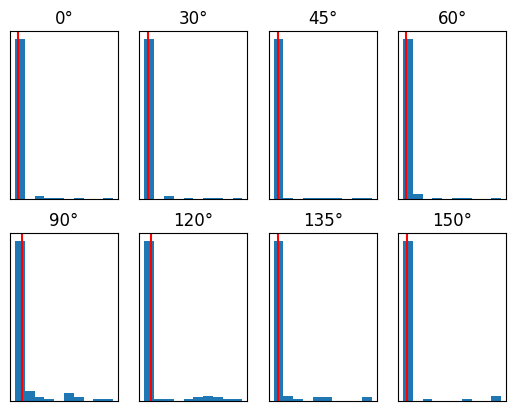

In [13]:
hist_V1(MFR4aa, naa, FR)

# LGN A - V1 B

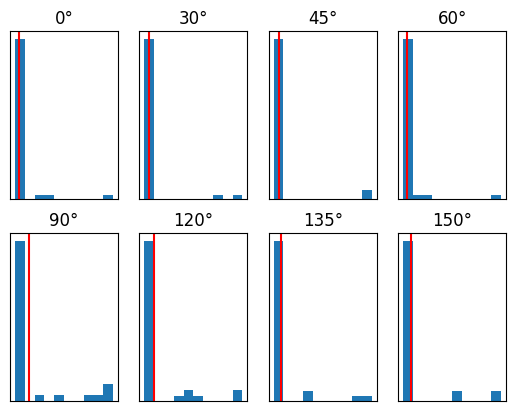

In [14]:
hist_V1(MFR4ab, nab, FR)

# LGN A - V1 C

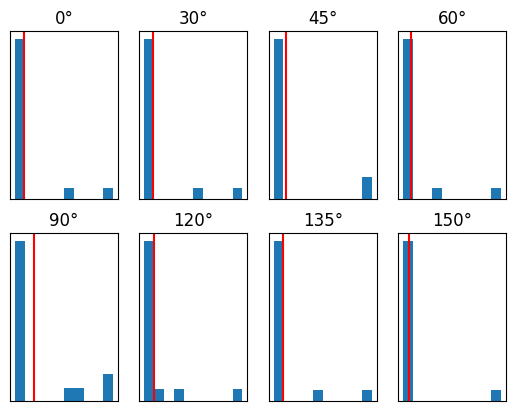

In [15]:
hist_V1(MFR4ac, nac, FR)

# LGN B - V1 A

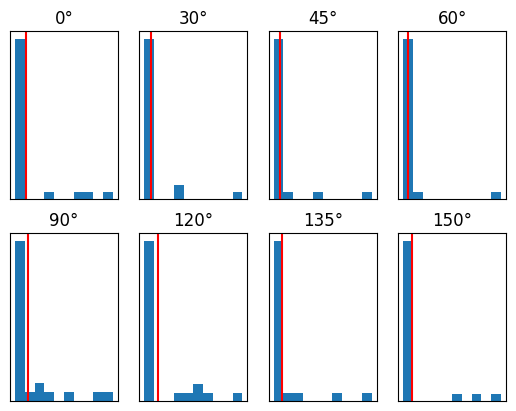

In [16]:
hist_V1(MFR4ba, nba, FR)

# LGN B - V1 B

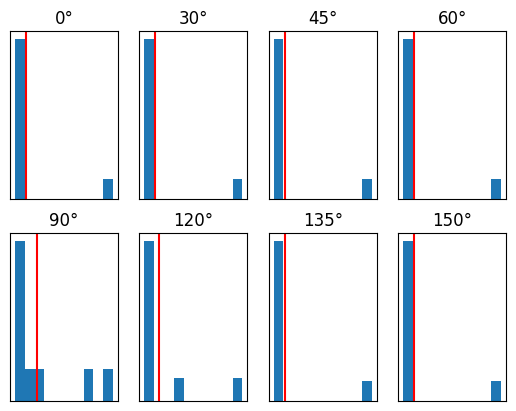

In [17]:
hist_V1(MFR4bb, nbb, FR)

# LGN B - V1 C

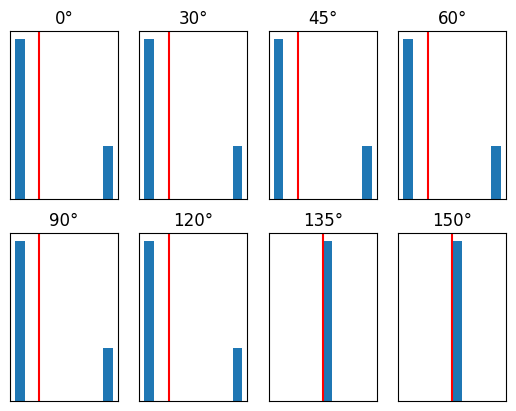

In [18]:
hist_V1(MFR4bc, nbc, FR)

# LGN C - V1 A

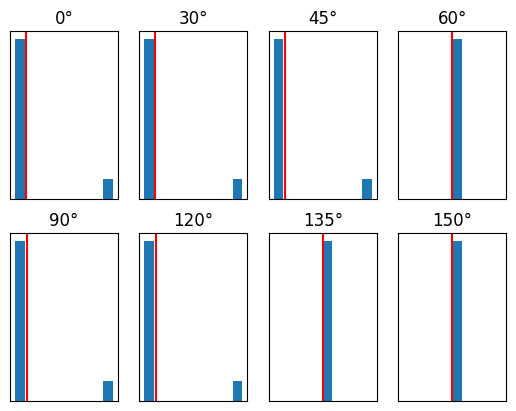

In [19]:
hist_V1(MFR4ca, nca, FR)

# LGN C - V1 B

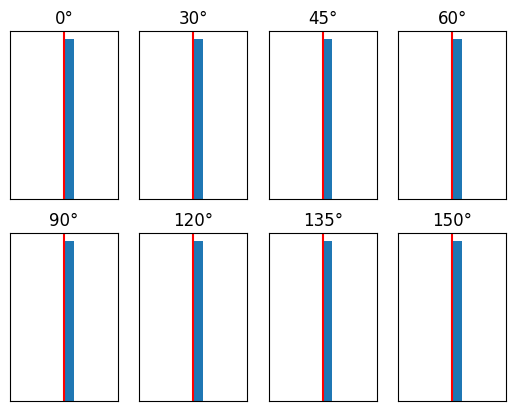

In [20]:
hist_V1(MFR4cb, ncb, FR)

# LGN C - V1 C

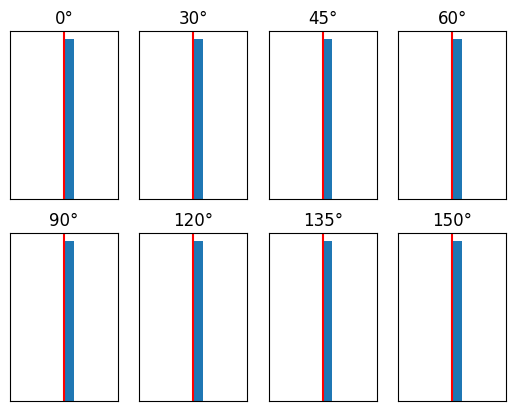

In [21]:
hist_V1(MFR4cc, ncc, FR)